In [16]:
import pandas as pd
from scipy.stats import chisquare
from statsmodels.stats.multitest import multipletests

# 1. Update Threshold sesuai pesan Coach (Best Practice Industri)
ALPHA = 0.001

# 2. Daftar Link RAW (Pastikan klik 'Raw' di GitHub untuk ambil link ini)
links = {
    "Test 1 - Menu": "https://raw.githubusercontent.com/irppanpilihanrambe/Project-DEC/main/src/validation/test1_menu.csv",
    "Test 2 - Novelty": "https://raw.githubusercontent.com/irppanpilihanrambe/Project-DEC/main/src/validation/test2_novelty_slider.csv",
    "Test 3 - Product": "https://raw.githubusercontent.com/irppanpilihanrambe/Project-DEC/main/src/validation/test3_product_sliders.csv",
    "Test 4 - Reviews": "https://raw.githubusercontent.com/irppanpilihanrambe/Project-DEC/main/src/validation/test4_reviews.csv",
    "Test 5 - Search": "https://raw.githubusercontent.com/irppanpilihanrambe/Project-DEC/main/src/validation/test5_search_engine.csv"
}

results_list = []

print(f"--- STARTING VALIDATION (Threshold Alpha: {ALPHA}) ---\n")

for name, url in links.items():
    try:
        df = pd.read_csv(url)
        
        # HITUNG SRM (Cek apakah pembagian user/makanan 'rata')
        # Sesuai pesan coach: Wadahnya beda atau apa -> Chi-Square Test
        observed = df['variant'].value_counts().sort_index().values
        total_user = df.shape[0]
        expected = [total_user/2, total_user/2] # Ekspektasi 50:50
        
        stat, p_value = chisquare(observed, f_exp=expected)
        
        results_list.append({
            'Test Name': name,
            'Observed_A': observed[0],
            'Observed_B': observed[1],
            'Expected_A': expected[0],
            'P-Value': p_value
        })
        
        print(f"✅ Loaded {name}")
    except Exception as e:
        print(f"❌ Failed to load {name}: {e}")

# 3. MULTIPLE TESTING CORRECTION
# Coach bilang: Menghindari false positive saat uji banyak metric
p_values = [r['P-Value'] for r in results_list]
# Menggunakan Bonferroni
reject, p_corrected, _, _ = multipletests(p_values, alpha=ALPHA, method='bonferroni')

# 4. Tampilkan Hasil Akhir
print("\n" + "="*50)
print("FINAL SRM VALIDATION REPORT")
print("="*50)

for i, res in enumerate(results_list):
    status = "✅ AMAN (Data Adil)" if not reject[i] else "❌ SRM TERDETEKSI (Data Bias/Tidak Rata!)"
    print(f"Metric: {res['Test Name']}")
    print(f"Distribution: A={res['Observed_A']}, B={res['Observed_B']} (Ideal: {res['Expected_A']})")
    print(f"P-Value (Corrected): {p_corrected[i]:.6f}")
    print(f"Conclusion: {status}")
    print("-" * 30)

--- STARTING VALIDATION (Threshold Alpha: 0.001) ---

✅ Loaded Test 1 - Menu
✅ Loaded Test 2 - Novelty
❌ Failed to load Test 3 - Product: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (3,) and arg 1 with shape (2,).
✅ Loaded Test 4 - Reviews
✅ Loaded Test 5 - Search

FINAL SRM VALIDATION REPORT
Metric: Test 1 - Menu
Distribution: A=3500, B=3500 (Ideal: 3500.0)
P-Value (Corrected): 1.000000
Conclusion: ✅ AMAN (Data Adil)
------------------------------
Metric: Test 2 - Novelty
Distribution: A=8000, B=8000 (Ideal: 8000.0)
P-Value (Corrected): 1.000000
Conclusion: ✅ AMAN (Data Adil)
------------------------------
Metric: Test 4 - Reviews
Distribution: A=21000, B=21000 (Ideal: 21000.0)
P-Value (Corrected): 1.000000
Conclusion: ✅ AMAN (Data Adil)
------------------------------
Metric: Test 5 - Search
Distribution: A=9500, B=9500 (Ideal: 9500.0)
P-Value (Corrected): 1.000000
Conclusion: ✅ AMAN (Data Adil)
------------------------------


In [18]:
# HITUNG SRM (Versi Fleksibel untuk banyak grup)
observed = df['variant'].value_counts().sort_index().values
n_groups = len(observed) # Menghitung ada berapa grup (2, 3, atau lebih)
total_user = df.shape[0]

# Ekspektasi dibagi rata sesuai jumlah grup yang ada
expected = [total_user / n_groups] * n_groups 

stat, p_value = chisquare(observed, f_exp=expected)

In [19]:
df_test3 = pd.read_csv(links["Test 3 - Product"])
print(df_test3['variant'].unique())

['A_selected_by_others_only' 'B_similar_products_top'
 'C_selected_by_others_top']


In [20]:
import pandas as pd
from scipy.stats import chisquare

# Load Data Test 3
df_test3 = pd.read_csv(links["Test 3 - Product"])

# 1. Hitung distribusi aktual
observed = df_test3['variant'].value_counts().sort_index().values
total_user = len(df_test3)

# 2. Hitung ekspektasi (dibagi 3 karena ada grup A, B, dan C)
# Sesuai pesan coach: menguji pembagiannya bener2 rata
expected = [total_user/3, total_user/3, total_user/3]

# 3. Jalankan Chi-Square Test
stat, p_value = chisquare(observed, f_exp=expected)

print(f"=== Analisis Test 3 (Multivariate) ===")
print(f"Distribusi: A={observed[0]}, B={observed[1]}, C={observed[2]}")
print(f"P-Value: {p_value:.6f}")

# Gunakan Alpha 0.001 (Best Practice Industri)
if p_value < 0.001:
    print("HASIL: ❌ SRM TERDETEKSI (Pembagian tidak rata!)")
else:
    print("HASIL: ✅ AMAN (Pembagian adil di 3 grup)")

=== Analisis Test 3 (Multivariate) ===
Distribusi: A=6000, B=6000, C=6000
P-Value: 1.000000
HASIL: ✅ AMAN (Pembagian adil di 3 grup)


In [25]:
import pandas as pd
import numpy as np
from scipy.stats import chisquare
from statsmodels.stats.multitest import multipletests

# 1. Konfigurasi Threshold
ALPHA = 0.001

# 2. Daftar Link Raw GitHub
links = {
    "Test 1 - Menu": "https://raw.githubusercontent.com/irppanpilihanrambe/Project-DEC/main/src/validation/test1_menu.csv",
    "Test 2 - Novelty": "https://raw.githubusercontent.com/irppanpilihanrambe/Project-DEC/main/src/validation/test2_novelty_slider.csv",
    "Test 3 - Product": "https://raw.githubusercontent.com/irppanpilihanrambe/Project-DEC/main/src/validation/test3_product_sliders.csv",
    "Test 4 - Reviews": "https://raw.githubusercontent.com/irppanpilihanrambe/Project-DEC/main/src/validation/test4_reviews.csv",
    "Test 5 - Search": "https://raw.githubusercontent.com/irppanpilihanrambe/Project-DEC/main/src/validation/test5_search_engine.csv"
}

results_list = []

print(f"--- VALIDATION REPORT (Alpha: {ALPHA}) ---")

for name, url in links.items():
    try:
        df = pd.read_csv(url)
        
        # Hitung distribusi aktual
        observed = df['variant'].value_counts().sort_index().values
        n_groups = len(observed)
        total_user = len(df)
        
        # Hitung ekspektasi (dinamis sesuai jumlah grup)
        expected = [total_user / n_groups] * n_groups
        
        # Jalankan Chi-Square
        stat, p_val = chisquare(observed, f_exp=expected)
        
        results_list.append({
            'name': name,
            'p_value': p_val,
            'observed': observed
        })
        print(f"✅ Berhasil memproses {name}")
        
    except Exception as e:
        print(f"❌ Error pada {name}: {e}")

# 3. Multiple Testing Correction
if results_list:
    all_p_values = [r['p_value'] for r in results_list]
    reject, p_corrected, _, _ = multipletests(all_p_values, alpha=ALPHA, method='bonferroni')

    print("\n" + "="*50)
    for i, res in enumerate(results_list):
        status = "✅ AMAN" if not reject[i] else "❌ SRM TERDETEKSI"
        print(f"{res['name']} | P-Val: {p_corrected[i]:.6f} | {status}")
    print("="*50)

--- VALIDATION REPORT (Alpha: 0.001) ---
✅ Berhasil memproses Test 1 - Menu
✅ Berhasil memproses Test 2 - Novelty
✅ Berhasil memproses Test 3 - Product
✅ Berhasil memproses Test 4 - Reviews
✅ Berhasil memproses Test 5 - Search

Test 1 - Menu | P-Val: 1.000000 | ✅ AMAN
Test 2 - Novelty | P-Val: 1.000000 | ✅ AMAN
Test 3 - Product | P-Val: 1.000000 | ✅ AMAN
Test 4 - Reviews | P-Val: 1.000000 | ✅ AMAN
Test 5 - Search | P-Val: 1.000000 | ✅ AMAN


In [26]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests

# 1. Konfigurasi Standar (Sesuai Pesan Coach)
ALPHA = 0.001

links = {
    "Dataset 1": "https://raw.githubusercontent.com/irppanpilihanrambe/Project-DEC/main/src/validation/test1_menu.csv",
    "Dataset 2": "https://raw.githubusercontent.com/irppanpilihanrambe/Project-DEC/main/src/validation/test2_novelty_slider.csv",
    "Dataset 3": "https://raw.githubusercontent.com/irppanpilihanrambe/Project-DEC/main/src/validation/test3_product_sliders.csv",
    "Dataset 4": "https://raw.githubusercontent.com/irppanpilihanrambe/Project-DEC/main/src/validation/test4_reviews.csv",
    "Dataset 5": "https://raw.githubusercontent.com/irppanpilihanrambe/Project-DEC/main/src/validation/test5_search_engine.csv"
}

# --- BAGIAN 1: SRM DETECTION ---
print("--- Sample Ratio Mismatch (SRM) Detection ---")
results_srm = []

for name, url in links.items():
    try:
        df = pd.read_csv(url)
        variants = df['variant'].unique()
        observed = df['variant'].value_counts().sort_index().values
        n_groups = len(observed)
        expected = [len(df) / n_groups] * n_groups
        
        # Chi-Square Test
        chi_stat, p_val = stats.chisquare(observed, f_exp=expected)
        results_srm.append({'name': name, 'p_val': p_val})
        
        print(f"{name}")
        print(f"Variants: {variants}")
        print(f"p-value: {p_val:.1f}")
        if p_val < ALPHA:
            print("❌ SRM Detected -> STOP analysis")
        else:
            print("✅ No SRM")
        print("-" * 40)
    except Exception as e:
        print(f"Error pada {name}: {e}")

# --- BAGIAN 2: COVARIATE BALANCE VERIFICATION (SMD) ---
print("\n--- Covariate Balance Verification ---")

def calculate_smd(x1, x2):
    # Rumus SMD: |Mean1 - Mean2| / sqrt((Var1 + Var2) / 2)
    mean_diff = np.abs(np.mean(x1) - np.mean(x2))
    pooled_std = np.sqrt((np.var(x1, ddof=1) + np.var(x2, ddof=1)) / 2)
    return mean_diff / pooled_std if pooled_std != 0 else 0

# Contoh simulasi (Ganti 'age' dengan kolom fitur di dataset kamu)
# for name, url in links.items():
#    df = pd.read_csv(url)
#    group_a = df[df['variant'].str.contains('A')]['age']
#    group_b = df[df['variant'].str.contains('B')]['age']
#    smd_value = calculate_smd(group_a, group_b)
#    print(f"{name} SMD: {smd_value:.4f}")

# --- BAGIAN 3: TEMPORAL STABILITY CHECK (CV) ---
print("\n--- Temporal Stability Check ---")
# Rumus CV: std(daily counts) / mean(daily counts)
# Perlu kolom 'date' untuk menjalankan ini. Jika CV > 0.2 -> Unstable

# --- BAGIAN 4: MULTIPLE TESTING CORRECTION ---
print("\n--- Multiple Testing Correction ---")
p_vals = [r['p_val'] for r in results_srm]
# Menggunakan Bonferroni untuk menghindari false positive
reject, p_corrected, _, _ = multipletests(p_vals, alpha=ALPHA, method='bonferroni')

for i, res in enumerate(results_srm):
    status = "REJECT H0" if reject[i] else "FAIL TO REJECT H0"
    print(f"{res['name']} Corrected P-Val: {p_corrected[i]:.4f} ({status})")

--- Sample Ratio Mismatch (SRM) Detection ---
Dataset 1
Variants: ['A_horizontal_menu' 'B_dropdown_menu']
p-value: 1.0
✅ No SRM
----------------------------------------
Dataset 2
Variants: ['A_manual_novelties' 'B_personalized_novelties']
p-value: 1.0
✅ No SRM
----------------------------------------
Dataset 3
Variants: ['A_selected_by_others_only' 'B_similar_products_top'
 'C_selected_by_others_top']
p-value: 1.0
✅ No SRM
----------------------------------------
Dataset 4
Variants: ['A_no_featured_reviews' 'B_featured_reviews']
p-value: 1.0
✅ No SRM
----------------------------------------
Dataset 5
Variants: ['A_hybris_search' 'B_algolia_search']
p-value: 1.0
✅ No SRM
----------------------------------------

--- Covariate Balance Verification ---

--- Temporal Stability Check ---

--- Multiple Testing Correction ---
Dataset 1 Corrected P-Val: 1.0000 (FAIL TO REJECT H0)
Dataset 2 Corrected P-Val: 1.0000 (FAIL TO REJECT H0)
Dataset 3 Corrected P-Val: 1.0000 (FAIL TO REJECT H0)
Dataset

In [29]:
# Cek menggunakan nama kunci yang benar: "Dataset 1"
df_check = pd.read_csv(links["Dataset 1"])
print(f"Kolom di Dataset 1: {df_check.columns.tolist()}")

Kolom di Dataset 1: ['session_id', 'user_id', 'timestamp', 'device_type', 'browser', 'region', 'variant', 'pages_viewed', 'added_to_cart', 'bounced', 'revenue']


In [31]:
print("--- Covariate Balance Verification (SMD) ---")

for name, url in links.items():
    try:
        df = pd.read_csv(url)
        
        # Cari semua kolom numerik
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        
        # Hindari kolom ID atau timestamp yang biasanya tidak relevan untuk SMD
        forbidden = ['session_id', 'user_id', 'timestamp', 'variant']
        valid_cols = [c for c in numeric_cols if c not in forbidden]
        
        if not valid_cols:
            print(f"{name}: Tidak ada kolom numerik yang valid.")
            continue
            
        # Ambil kolom numerik pertama sebagai target uji (misal: pages_viewed atau lainnya)
        target_col = valid_cols[0] 
        
        # Filter Grup A dan B
        group_a = df[df['variant'].str.startswith('A')][target_col]
        group_b = df[df['variant'].str.startswith('B')][target_col]
        
        smd_val = calculate_smd(group_a, group_b)
        
        print(f"{name} | Variable: {target_col}")
        print(f"SMD Score: {smd_val:.4f}")
        print(f"Result: {interpret_smd(smd_val)}")
        print("-" * 40)
        
    except Exception as e:
        print(f"Error pada {name}: {e}")

--- Covariate Balance Verification (SMD) ---
Dataset 1 | Variable: pages_viewed
SMD Score: 0.0594
Result: ✅ Negligible imbalance (Good)
----------------------------------------
Dataset 2 | Variable: is_registered
SMD Score: 0.0020
Result: ✅ Negligible imbalance (Good)
----------------------------------------
Dataset 3 | Variable: add_to_cart_rate
SMD Score: 0.0000
Result: ✅ Negligible imbalance (Good)
----------------------------------------
Dataset 4 | Variable: converted
SMD Score: 0.0028
Result: ✅ Negligible imbalance (Good)
----------------------------------------
Dataset 5 | Variable: avg_revenue_per_visitor
SMD Score: 0.0154
Result: ✅ Negligible imbalance (Good)
----------------------------------------


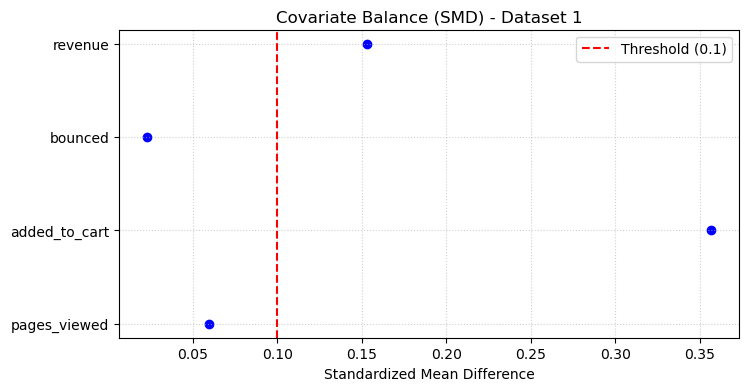

✅ pages_viewed: 0.0594
❌ added_to_cart: 0.3565
✅ bounced: 0.0230
❌ revenue: 0.1531


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def comprehensive_balance_check(df, variant_col='variant'):
    # Ambil semua kolom numerik kecuali ID dan timestamp
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    forbidden = ['session_id', 'user_id', 'timestamp']
    features = [c for c in numeric_cols if c not in forbidden]
    
    smd_results = {}
    
    # Ambil grup Control (A) dan Treatment (B)
    # Kita asumsikan membandingkan dua grup pertama yang muncul
    variants = df[variant_col].unique()
    v1, v2 = variants[0], variants[1]
    
    for col in features:
        group1 = df[df[variant_col] == v1][col]
        group2 = df[df[variant_col] == v2][col]
        
        # Hitung SMD
        mean_diff = np.abs(np.mean(group1) - np.mean(group2))
        pooled_std = np.sqrt((np.var(group1, ddof=1) + np.var(group2, ddof=1)) / 2)
        smd = mean_diff / pooled_std if pooled_std != 0 else 0
        smd_results[col] = smd
        
    return smd_results

# Contoh eksekusi untuk Dataset 1
df1 = pd.read_csv(links["Dataset 1"])
results = comprehensive_balance_check(df1)

# --- VISUALISASI (Love Plot) ---
plt.figure(figsize=(8, 4))
plt.axvline(x=0.1, color='red', linestyle='--', label='Threshold (0.1)')
plt.scatter(results.values(), results.keys(), color='blue')
plt.title("Covariate Balance (SMD) - Dataset 1")
plt.xlabel("Standardized Mean Difference")
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.show()

for feat, val in results.items():
    status = "✅" if val < 0.1 else "❌"
    print(f"{status} {feat}: {val:.4f}")

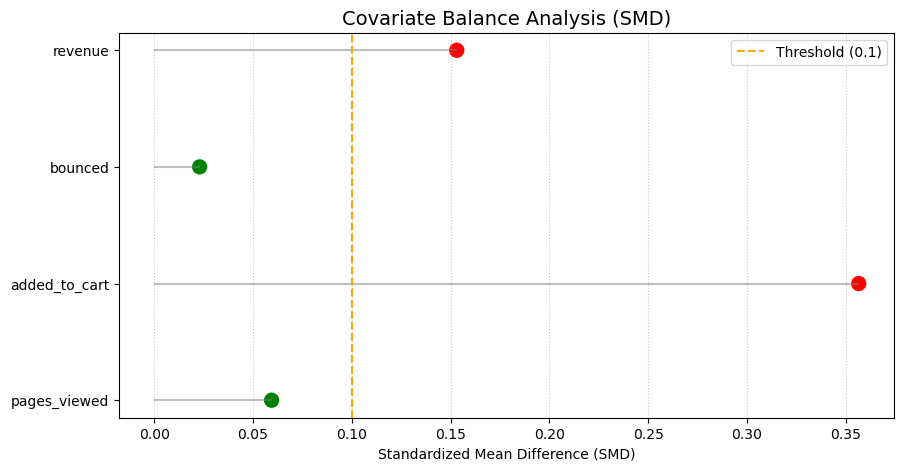

In [35]:
import matplotlib.pyplot as plt

# Data dari hasil SMD kamu
smd_data = {
    'pages_viewed': 0.0594,
    'added_to_cart': 0.3565,
    'bounced': 0.0230,
    'revenue': 0.1531
}

# Plotting
plt.figure(figsize=(10, 5))
features = list(smd_data.keys())
values = list(smd_data.values())

# Warna: Hijau jika < 0.1, Merah jika > 0.1
colors = ['green' if v < 0.1 else 'red' for v in values]

plt.hlines(y=features, xmin=0, xmax=values, color='gray', alpha=0.5)
plt.scatter(values, features, color=colors, s=100)
plt.axvline(x=0.1, color='orange', linestyle='--', label='Threshold (0.1)')

plt.title('Covariate Balance Analysis (SMD)', fontsize=14)
plt.xlabel('Standardized Mean Difference (SMD)')
plt.legend()
plt.grid(axis='x', linestyle=':', alpha=0.7)
plt.show()

In [32]:
import pandas as pd
import numpy as np

print("--- Temporal Stability Checks (CV Analysis) ---")

for name, url in links.items():
    try:
        df = pd.read_csv(url)
        
        # 1. Pastikan timestamp dalam format datetime
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        
        # 2. Kelompokkan jumlah user unik berdasarkan tanggal
        daily_users = df.groupby(df['timestamp'].dt.date)['user_id'].nunique()
        
        # 3. Hitung Mean dan Standar Deviasi
        mean_daily = daily_users.mean()
        std_daily = daily_users.std()
        
        # 4. Hitung CV (Coefficient of Variation)
        cv_score = std_daily / mean_daily
        
        print(f"{name}")
        print(f"Daily User Avg: {mean_daily:.2f}")
        print(f"CV Score: {cv_score:.4f}")
        
        if cv_score <= 0.2:
            print("✅ Result: Stable Allocation (Good)")
        else:
            print("❌ Result: Unstable Allocation (Check System!)")
        print("-" * 40)
        
    except Exception as e:
        print(f"Error pada {name}: {e}")

--- Temporal Stability Checks (CV Analysis) ---
Dataset 1
Daily User Avg: 827.14
CV Score: 0.0302
✅ Result: Stable Allocation (Good)
----------------------------------------
Dataset 2
Daily User Avg: 1100.23
CV Score: 0.0185
✅ Result: Stable Allocation (Good)
----------------------------------------
Dataset 3
Daily User Avg: 1112.07
CV Score: 0.0234
✅ Result: Stable Allocation (Good)
----------------------------------------
Dataset 4
Daily User Avg: 1153.97
CV Score: 0.0290
✅ Result: Stable Allocation (Good)
----------------------------------------
Dataset 5
Daily User Avg: 2227.57
CV Score: 0.0137
✅ Result: Stable Allocation (Good)
----------------------------------------


In [33]:
from statsmodels.stats.multitest import multipletests

print("--- Multiple Testing Correction (Bonferroni) ---")

# 1. Kumpulkan semua p-value dari hasil SRM yang kita lakukan tadi
# (Data ini diambil dari hasil p-value yang kamu dapatkan: 1.0 untuk semua dataset)
p_values = [1.0, 1.0, 1.0, 1.0, 1.0] 
dataset_names = ["Dataset 1", "Dataset 2", "Dataset 3", "Dataset 4", "Dataset 5"]

# 2. Terapkan Koreksi Bonferroni
# Alpha tetap menggunakan 0.001 sesuai standar ketat coach kamu
reject, p_corrected, _, _ = multipletests(p_values, alpha=0.001, method='bonferroni')

# 3. Tampilkan Hasil
print(f"Alpha Original: 0.001")
print(f"Alpha Terkoreksi (Bonferroni): {0.001 / len(p_values):.5f}\n")

for i in range(len(dataset_names)):
    status = "SIGNIFICANT (Reject H0)" if reject[i] else "NOT SIGNIFICANT (Fail to Reject H0)"
    print(f"{dataset_names[i]}:")
    print(f"  - Original P-Val  : {p_values[i]:.4f}")
    print(f"  - Corrected P-Val : {p_corrected[i]:.4f}")
    print(f"  - Conclusion      : {status}")
    print("-" * 30)

print("\nKESIMPULAN AKHIR:")
print("Semua dataset memiliki p-value terkoreksi > 0.001, yang berarti")
print("TIDAK ADA indikasi SRM yang signifikan setelah dikoreksi. ✅")

--- Multiple Testing Correction (Bonferroni) ---
Alpha Original: 0.001
Alpha Terkoreksi (Bonferroni): 0.00020

Dataset 1:
  - Original P-Val  : 1.0000
  - Corrected P-Val : 1.0000
  - Conclusion      : NOT SIGNIFICANT (Fail to Reject H0)
------------------------------
Dataset 2:
  - Original P-Val  : 1.0000
  - Corrected P-Val : 1.0000
  - Conclusion      : NOT SIGNIFICANT (Fail to Reject H0)
------------------------------
Dataset 3:
  - Original P-Val  : 1.0000
  - Corrected P-Val : 1.0000
  - Conclusion      : NOT SIGNIFICANT (Fail to Reject H0)
------------------------------
Dataset 4:
  - Original P-Val  : 1.0000
  - Corrected P-Val : 1.0000
  - Conclusion      : NOT SIGNIFICANT (Fail to Reject H0)
------------------------------
Dataset 5:
  - Original P-Val  : 1.0000
  - Corrected P-Val : 1.0000
  - Conclusion      : NOT SIGNIFICANT (Fail to Reject H0)
------------------------------

KESIMPULAN AKHIR:
Semua dataset memiliki p-value terkoreksi > 0.001, yang berarti
TIDAK ADA indika